In [25]:
# Cell 1 - imports and reload dataset
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Use relative path (one folder up)
file_path = "../data/project_risk_raw_dataset.csv"

# Load dataset
df = pd.read_csv(file_path)

# Basic info
print("✅ Loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist()[:10], "...")  # show first 10 column names
print("\nMissing values summary (top 5):")
print(df.isnull().sum().sort_values(ascending=False).head(5))

# Preview first 3 rows
df.head(3)

✅ Loaded successfully!
Shape: (4000, 51)

Columns: ['Project_ID', 'Project_Type', 'Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Methodology_Used', 'Team_Experience_Level', 'Past_Similar_Projects'] ...

Missing values summary (top 5):
Tech_Environment_Stability      2619
Risk_Management_Maturity         791
Change_Control_Maturity          780
Project_ID                         0
Key_Stakeholder_Availability       0
dtype: int64


,Project_ID,Project_Type,Team_Size,Project_Budget_USD,Estimated_Timeline_Months,Complexity_Score,Stakeholder_Count,Methodology_Used,Team_Experience_Level,Past_Similar_Projects,...,Industry_Volatility,Client_Experience_Level,Change_Control_Maturity,Risk_Management_Maturity,Team_Colocation,Documentation_Quality,Project_Start_Month,Current_Phase_Duration_Months,Seasonal_Risk_Factor,Risk_Level
0,PROJ_0001,Construction,32,1526276.55,32,9.70,16,Waterfall,Senior,3,...,Extreme,First-time,Basic,Basic,Fully Colocated,Good,10,5,1.0,High
1,PROJ_0002,Manufacturing,2,390790.15,9,2.72,9,Kanban,Mixed,0,...,Stable,Occasional,Advanced,Formal,Fully Remote,Poor,9,3,1.0,Low
2,PROJ_0003,Manufacturing,2,246674.76,6,2.04,7,Agile,Mixed,1,...,Stable,Regular,NaN,NaN,Hybrid,Good,5,1,1.0,Medium


In [26]:
# ==========================
# 🎯 STEP 1 — Feature Engineering
# ==========================

# Convert string columns to numeric before calculations
df['Project_Budget_USD'] = pd.to_numeric(df['Project_Budget_USD'], errors='coerce')
df['Team_Size'] = pd.to_numeric(df['Team_Size'], errors='coerce')
df['Estimated_Timeline_Months'] = pd.to_numeric(df['Estimated_Timeline_Months'], errors='coerce')
df['Stakeholder_Count'] = pd.to_numeric(df['Stakeholder_Count'], errors='coerce')

# Create new derived features to make data more predictive
df['Budget_Per_TeamMember'] = df['Project_Budget_USD'] / (df['Team_Size'] + 1e-5)
df['Schedule_Pressure_Index'] = df['Estimated_Timeline_Months'] / (df['Stakeholder_Count'] + 1e-5)

# Aggregate instability and complexity indicators
instability_cols = ['Integration_Complexity', 'Requirement_Stability', 'Market_Volatility']
# Ensure these columns are numeric too
for col in instability_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['Complexity_Index'] = df[instability_cols].mean(axis=1)

# Interaction-style feature
if 'Client_Experience_Level' in df.columns and 'Team_Experience_Level' in df.columns:
    df['Client_Experience_Level'] = pd.to_numeric(df['Client_Experience_Level'], errors='coerce')
    df['Team_Experience_Level'] = pd.to_numeric(df['Team_Experience_Level'], errors='coerce')
    df['Experience_Gap'] = df['Client_Experience_Level'] - df['Team_Experience_Level']

# Binary indicator: geographically distributed team
if 'Geographical_Distribution' in df.columns:
    df['Geographical_Distribution'] = pd.to_numeric(df['Geographical_Distribution'], errors='coerce')
    df['Distributed_Team'] = (df['Geographical_Distribution'] > 1).astype(int)

print("✅ New features added successfully!")
print("Columns now:", df.shape[1])


✅ New features added successfully!
Columns now: 56


In [27]:
'Risk_Level' in df.columns


True

In [28]:
# Cell 2 - check target distribution
target_col = 'Risk_Level'
print("Target column:", target_col)
print("Unique values and counts:")
print(df[target_col].value_counts(dropna=False))


Target column: Risk_Level
Unique values and counts:
Risk_Level
Medium      1396
High        1036
Low          806
Critical     762
Name: count, dtype: int64


In [29]:
# Cell 3 - choose candidate features
exclude = {target_col, 'Project_ID'}   # exclude ID and target
# auto detect
numeric_features = df.select_dtypes(include=['int64','float64']).columns.difference(exclude).tolist()
categorical_features = df.select_dtypes(include=['object','category']).columns.difference(exclude).tolist()

print("Numeric features (count):", len(numeric_features))
print(numeric_features[:30])
print("\nCategorical features (count):", len(categorical_features))
print(categorical_features[:30])


Numeric features (count): 32
['Budget_Per_TeamMember', 'Budget_Utilization_Rate', 'Change_Request_Frequency', 'Client_Experience_Level', 'Communication_Frequency', 'Complexity_Index', 'Complexity_Score', 'Cross_Functional_Dependencies', 'Current_Phase_Duration_Months', 'Estimated_Timeline_Months', 'Experience_Gap', 'External_Dependencies_Count', 'Geographical_Distribution', 'Historical_Risk_Incidents', 'Integration_Complexity', 'Market_Volatility', 'Organizational_Change_Frequency', 'Past_Similar_Projects', 'Previous_Delivery_Success_Rate', 'Project_Budget_USD', 'Project_Start_Month', 'Requirement_Stability', 'Resource_Availability', 'Schedule_Pressure', 'Schedule_Pressure_Index', 'Seasonal_Risk_Factor', 'Stakeholder_Count', 'Team_Experience_Level', 'Team_Size', 'Team_Turnover_Rate']

Categorical features (count): 21
['Change_Control_Maturity', 'Contract_Type', 'Data_Security_Requirements', 'Documentation_Quality', 'Executive_Sponsorship', 'Funding_Source', 'Industry_Volatility', 'Key_

In [30]:
# Cell 4 - Recommended feature subset (numeric + categorical)

# Numeric features
numeric_features = [
    'Team_Size',
    'Project_Budget_USD',
    'Estimated_Timeline_Months',
    'Complexity_Score',
    'Stakeholder_Count',
    'Cross_Functional_Dependencies',
    'External_Dependencies_Count',
    'Team_Turnover_Rate',
    'Historical_Risk_Incidents',
    'Budget_Utilization_Rate',
    'Schedule_Pressure',
    'Previous_Delivery_Success_Rate',
    'Technical_Debt_Level',
    'Current_Phase_Duration_Months',
    'Seasonal_Risk_Factor'
]

# Categorical features
categorical_features = [
    'Project_Type',
    'Methodology_Used',
    'Team_Experience_Level',
    'Project_Phase',
    'Executive_Sponsorship',
    'Org_Process_Maturity',
    'Risk_Management_Maturity',
    'Priority_Level'
]

print("Using numeric features:", len(numeric_features))
print(numeric_features)
print("\nUsing categorical features:", len(categorical_features))
print(categorical_features)


Using numeric features: 15
['Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Cross_Functional_Dependencies', 'External_Dependencies_Count', 'Team_Turnover_Rate', 'Historical_Risk_Incidents', 'Budget_Utilization_Rate', 'Schedule_Pressure', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Current_Phase_Duration_Months', 'Seasonal_Risk_Factor']

Using categorical features: 8
['Project_Type', 'Methodology_Used', 'Team_Experience_Level', 'Project_Phase', 'Executive_Sponsorship', 'Org_Process_Maturity', 'Risk_Management_Maturity', 'Priority_Level']


In [31]:
# Cell 5 - preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric preprocessing: fill missing values + scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: fill missing values + one-hot encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both into a single transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
], remainder='drop')  # drop any other columns

print("✅ Preprocessing pipeline created successfully.")
print("Numeric features handled:", len(numeric_features))
print("Categorical features handled:", len(categorical_features))


✅ Preprocessing pipeline created successfully.
Numeric features handled: 15
Categorical features handled: 8


In [50]:
# Quick fix: Create 'models' directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)  # 'exist_ok=True' avoids errors if it already exists
# Create and fit the label encoder first
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()  # Create the label encoder object
# Now re-save the encoder
import joblib
joblib.dump(le, 'models/label_encoder.pkl')
print("✅ 'models/' folder created & label encoder saved!")

✅ 'models/' folder created & label encoder saved!


In [33]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\dell\MSc_Project\AI_Risk_Assessor\notebooks


In [52]:
# ===============================
# ✅ Cell — Create, Save & Verify Label Encoder
# ===============================
from sklearn.preprocessing import LabelEncoder
import joblib

# Step 1: Define your known class labels (order does not matter)
risk_labels = ['Low', 'Medium', 'High', 'Critical']

# Step 2: Fit the LabelEncoder
le = LabelEncoder()
le.fit(risk_labels)

# Step 3: Save the fitted encoder
joblib.dump(le, 'models/label_encoder.pkl')
print("✅ Label Encoder fitted and saved successfully to 'models/label_encoder.pkl'")

# Step 4: Load it back to verify
le_loaded = joblib.load('models/label_encoder.pkl')
print("\n✅ Label Encoder loaded successfully!")
print("Stored Classes:", le_loaded.classes_)

# Step 5: Test encoding and decoding
sample_labels = ['Low', 'Critical', 'Medium']
encoded = le_loaded.transform(sample_labels)
decoded = le_loaded.inverse_transform(encoded)

print("\nExample Encoding:")
for label, code in zip(sample_labels, encoded):
    print(f"  {label:>8} → {code}")

print("\nExample Decoding:")
for code, label in zip(encoded, decoded):
    print(f"  {code} → {label}")


✅ Label Encoder fitted and saved successfully to 'models/label_encoder.pkl'

✅ Label Encoder loaded successfully!
Stored Classes: ['Critical' 'High' 'Low' 'Medium']

Example Encoding:
       Low → 2
  Critical → 0
    Medium → 3

Example Decoding:
  2 → Low
  0 → Critical
  3 → Medium


In [35]:
# Cell 6 - Label encoding and train/test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Encode the target variable (Risk_Level) to numeric labels
le = LabelEncoder()
df['Risk_Level_Encoded'] = le.fit_transform(df['Risk_Level'])  # Fits on whole df for simplicity (small dataset; in prod, fit only on train)

# Quick check: See the mapping (e.g., {'Critical': 0, 'High': 1, 'Low': 2, 'Medium': 3})
print("Target label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Step 2: Prepare features (X) and target (y)
X = df.drop(['Risk_Level', 'Risk_Level_Encoded'], axis=1)  # Drop original + encoded for clean X
y = df['Risk_Level_Encoded']  # Use encoded y

# Step 3: Split into train/test (80/20, stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # random_state for reproducibility
)

# Step 4: Fit preprocessor on train and transform both
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # No fit here!

# Output shapes and class distribution check
print("\n✅ Train/Test split complete!")
print(f"X_train shape: {X_train_processed.shape}")
print(f"X_test shape: {X_test_processed.shape}")
print(f"y_train distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"y_test distribution:\n{pd.Series(y_test).value_counts().sort_index()}")

# Optional: Save the label encoder for later (inverse transform predictions back to labels)
import joblib
joblib.dump(le, 'models/label_encoder.pkl')
print("\n💾 Label encoder saved as 'models/label_encoder.pkl'")

Target label mapping: {'Critical': 0, 'High': 1, 'Low': 2, 'Medium': 3}

✅ Train/Test split complete!
X_train shape: (3200, 47)
X_test shape: (800, 47)
y_train distribution:
Risk_Level_Encoded
0     609
1     829
2     645
3    1117
Name: count, dtype: int64
y_test distribution:
Risk_Level_Encoded
0    153
1    207
2    161
3    279
Name: count, dtype: int64

💾 Label encoder saved as 'models/label_encoder.pkl'


C:\Users\dell\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression Accuracy: 0.5025

Classification Report:
              precision    recall  f1-score   support

    Critical       0.58      0.60      0.59       153
        High       0.45      0.29      0.36       207
         Low       0.51      0.50      0.51       161
      Medium       0.48      0.60      0.54       279

    accuracy                           0.50       800
   macro avg       0.51      0.50      0.50       800
weighted avg       0.50      0.50      0.49       800



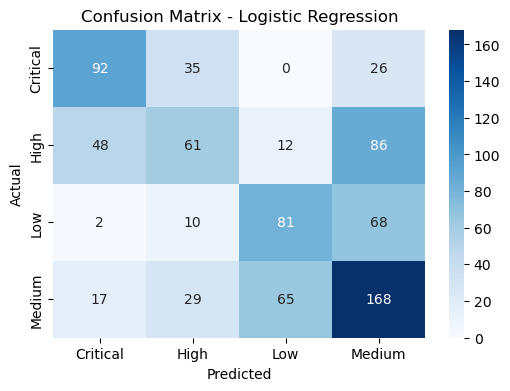


💾 Model saved as 'models/logistic_regression_model.pkl'


In [36]:
# Cell 7 - Logistic Regression Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')

# Step 2: Train (fit) on the processed training data
log_reg.fit(X_train_processed, y_train)

# Step 3: Predict on test data
y_pred = log_reg.predict(X_test_processed)

# Step 4: Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Logistic Regression Accuracy: {acc:.4f}")

# Step 5: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Step 6: Confusion matrix for visual insight
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Step 7: Save the trained model
import joblib
joblib.dump(log_reg, 'models/logistic_regression_model.pkl')
print("\n💾 Model saved as 'models/logistic_regression_model.pkl'")



✅ Random Forest Accuracy: 0.4662

Classification Report:
              precision    recall  f1-score   support

    Critical       0.58      0.43      0.49       153
        High       0.40      0.31      0.35       207
         Low       0.53      0.36      0.43       161
      Medium       0.44      0.66      0.53       279

    accuracy                           0.47       800
   macro avg       0.49      0.44      0.45       800
weighted avg       0.48      0.47      0.46       800



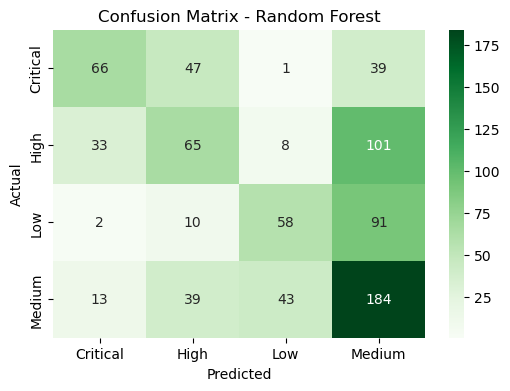


💾 Model saved as 'models/random_forest_model.pkl'


In [37]:
# Cell 8 - Random Forest Model Training & Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Step 1: Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees in the forest
    max_depth=None,         # let trees grow fully (can tune later)
    random_state=42,
    n_jobs=-1               # use all CPU cores for speed
)

# Step 2: Train the model
rf_model.fit(X_train_processed, y_train)

# Step 3: Predict on test data
y_pred_rf = rf_model.predict(X_test_processed)

# Step 4: Evaluate performance
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"✅ Random Forest Accuracy: {acc_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Step 5: Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.savefig('../figures/confusion_matrix_rf.png', dpi=300, bbox_inches='tight')
plt.show()



# Step 6: Save model
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("\n💾 Model saved as 'models/random_forest_model.pkl'")


✅ Model Performance Comparison:
                 Model  Accuracy  F1-Score
0  Logistic Regression    0.5025    0.4942
1        Random Forest    0.4662    0.4570


C:\Users\dell\AppData\Local\Temp\ipykernel_21272\1276678638.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='cool')


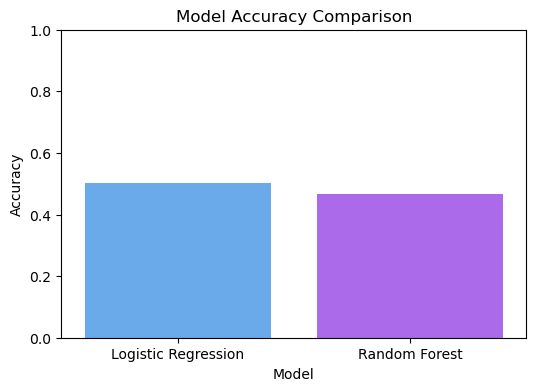

C:\Users\dell\AppData\Local\Temp\ipykernel_21272\1276678638.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='Greens_r')


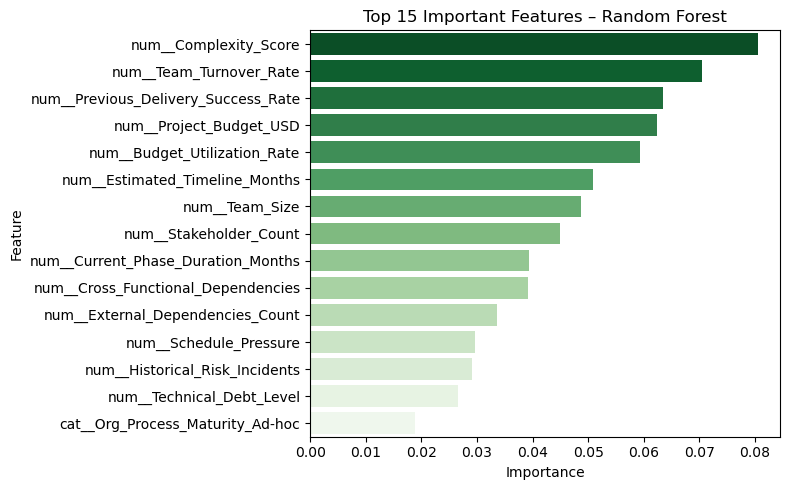

💾 Top 15 feature importances saved to 'models/feature_importance_top15.csv'


In [38]:
# Cell 9 — Compare Models & Show Feature Importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import joblib

# Step 1️⃣ – Load saved models (safety check)
log_reg_loaded = joblib.load('models/logistic_regression_model.pkl')
rf_loaded      = joblib.load('models/random_forest_model.pkl')

# Step 2️⃣ – Compare overall performance
acc_log = accuracy_score(y_test, log_reg_loaded.predict(X_test_processed))
acc_rf  = accuracy_score(y_test, rf_loaded.predict(X_test_processed))
f1_log  = f1_score(y_test, log_reg_loaded.predict(X_test_processed), average='weighted')
f1_rf   = f1_score(y_test, rf_loaded.predict(X_test_processed), average='weighted')

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [acc_log, acc_rf],
    'F1-Score': [f1_log, f1_rf]
})

print("✅ Model Performance Comparison:")
print(results.round(4))

# Step 3️⃣ – Visualize comparison
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=results, palette='cool')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.show()

# Step 4️⃣ – Feature importance (Random Forest)
if hasattr(rf_loaded, 'feature_importances_'):
    feature_names = preprocessor.get_feature_names_out()
    importances = rf_loaded.feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(8,5))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='Greens_r')
    #sns.barplot(x='Model', y='Accuracy', data=results, hue='Model', legend=False, palette='cool')
    plt.title('Top 15 Important Features – Random Forest')
    plt.tight_layout()
    # Save top 15 feature importance chart
    plt.savefig('../figures/feature_importance_rf.png', dpi=300, bbox_inches='tight')
    plt.show()


    

    feat_imp_df.to_csv('models/feature_importance_top15.csv', index=False)
    print("💾 Top 15 feature importances saved to 'models/feature_importance_top15.csv'")
else:
    print("⚠️ Feature importance not available for this model.")


In [39]:
# Cell 10 - Hyperparameter Tuning for Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib

# Step 1️⃣ - Define the model
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)

# Step 2️⃣ - Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Step 3️⃣ - Set up grid search (5-fold cross-validation)
grid_search = GridSearchCV(
    estimator=rf_tune,
    param_grid=param_grid,
    cv=5,               # 5 different train/test splits
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Step 4️⃣ - Run the search on training data
grid_search.fit(X_train_processed, y_train)

# Step 5️⃣ - Get best parameters and accuracy
print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)

print(f"\n✅ Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Step 6️⃣ - Evaluate on test set
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test_processed)
test_acc = accuracy_score(y_test, y_pred_best)

print(f"\n✅ Test Set Accuracy (After Tuning): {test_acc:.4f}")

# Step 7️⃣ - Save tuned model
joblib.dump(best_rf_model, 'models/random_forest_tuned.pkl')
print("\n💾 Tuned Random Forest model saved as 'models/random_forest_tuned.pkl'")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\dell\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



✅ Best Parameters Found:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

✅ Best Cross-Validation Accuracy: 0.4738

✅ Test Set Accuracy (After Tuning): 0.4612

💾 Tuned Random Forest model saved as 'models/random_forest_tuned.pkl'


✅ Final Model Performance Comparison:
                      Model  Accuracy
0       Logistic Regression    0.5025
1  Random Forest (Baseline)    0.4662
2     Random Forest (Tuned)    0.4612


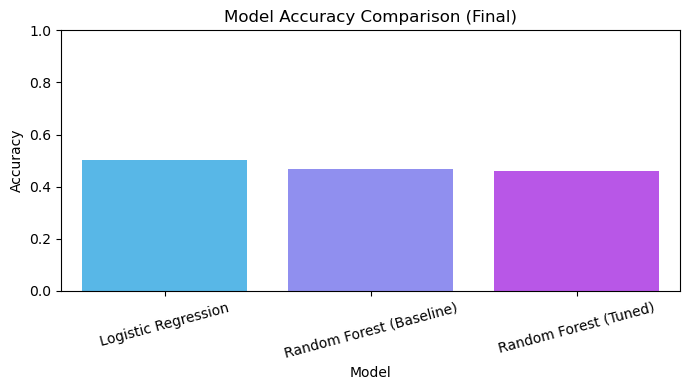

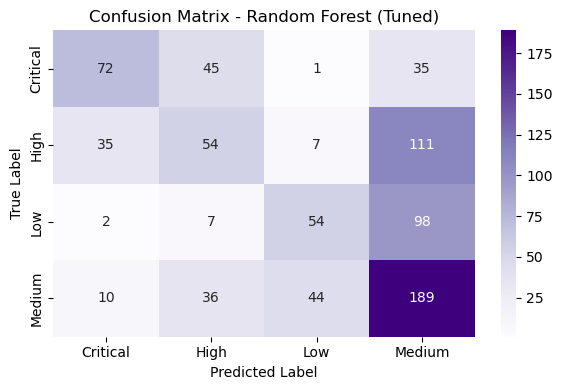


Classification Report - Random Forest (Tuned):
              precision    recall  f1-score   support

    Critical       0.61      0.47      0.53       153
        High       0.38      0.26      0.31       207
         Low       0.51      0.34      0.40       161
      Medium       0.44      0.68      0.53       279

    accuracy                           0.46       800
   macro avg       0.48      0.44      0.44       800
weighted avg       0.47      0.46      0.45       800


💾 Final comparison saved as 'models/final_model_comparison.csv'


In [42]:
# Cell 11 - Final Evaluation & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Step 1️⃣ - Load all three models
log_reg_model = joblib.load('models/logistic_regression_model.pkl')
rf_baseline   = joblib.load('models/random_forest_model.pkl')
rf_tuned      = joblib.load('models/random_forest_tuned.pkl')

# Step 2️⃣ - Evaluate on test data
acc_log = accuracy_score(y_test, log_reg_model.predict(X_test_processed))
acc_rf_base = accuracy_score(y_test, rf_baseline.predict(X_test_processed))
acc_rf_tuned = accuracy_score(y_test, rf_tuned.predict(X_test_processed))

results_final = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest (Baseline)', 'Random Forest (Tuned)'],
    'Accuracy': [acc_log, acc_rf_base, acc_rf_tuned]
})

print("✅ Final Model Performance Comparison:")
print(results_final.round(4))

# Step 3️⃣ - Bar chart comparison
plt.figure(figsize=(7,4))
sns.barplot(x='Model', y='Accuracy', data=results_final, hue='Model', legend=False, palette='cool')
plt.title('Model Accuracy Comparison (Final)')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Step 4️⃣ - Confusion Matrix for Tuned Model
y_pred_tuned = rf_tuned.predict(X_test_processed)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Step 5️⃣ - Classification Report for Tuned Model
print("\nClassification Report - Random Forest (Tuned):")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

# Step 6️⃣ - Save final results for report
results_final.to_csv('models/final_model_comparison.csv', index=False)
print("\n💾 Final comparison saved as 'models/final_model_comparison.csv'")


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import joblib

# Base model
rf = RandomForestClassifier(random_state=42)

# Define parameter space (keep it small to run fast)
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [8, 12, 16, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                     # number of random combos to test
    scoring='f1_weighted',         # optimize for balanced accuracy
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_processed, y_train)

# Evaluate best model
best_rf = rf_random.best_estimator_
y_pred_best = best_rf.predict(X_test_processed)

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("✅ Best Parameters:", rf_random.best_params_)
print(f"🎯 Accuracy: {acc_best:.3f}")
print(f"🎯 F1 Score: {f1_best:.3f}")

# Save best model
joblib.dump(best_rf, 'models/random_forest_randomsearch.pkl')
print("Model saved as random_forest_randomsearch.pkl")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 16, 'class_weight': 'balanced'}
🎯 Accuracy: 0.464
🎯 F1 Score: 0.453
Model saved as random_forest_randomsearch.pkl


In [44]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print("✅ After SMOTE:")
print("Before:", y_train.value_counts().to_dict())
print("After:",  pd.Series(y_train_res).value_counts().to_dict())

# Train a new Random Forest on balanced data
rf_smote = RandomForestClassifier(
    n_estimators=400,
    max_depth=16,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight=None,  # SMOTE already balances
    random_state=42
)

rf_smote.fit(X_train_res, y_train_res)

# Evaluate on test set
y_pred_smote = rf_smote.predict(X_test_processed)
acc_smote = accuracy_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')

print(f"🎯 Accuracy after SMOTE: {acc_smote:.3f}")
print(f"🎯 F1 Score after SMOTE: {f1_smote:.3f}")

# Save model
joblib.dump(rf_smote, 'models/random_forest_smote.pkl')
print("Model saved as random_forest_smote.pkl")


✅ After SMOTE:
Before: {3: 1117, 1: 829, 2: 645, 0: 609}
After: {3: 1117, 2: 1117, 1: 1117, 0: 1117}
🎯 Accuracy after SMOTE: 0.491
🎯 F1 Score after SMOTE: 0.489
Model saved as random_forest_smote.pkl


In [45]:
# First, install the xgboost package
#!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib

# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',   # since it's multi-class
    num_class=4,                 # 4 risk levels
    random_state=42
)

# Train on SMOTE-balanced data
xgb_model.fit(X_train_res, y_train_res)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test_processed)

# Evaluate
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"🎯 XGBoost Accuracy: {acc_xgb:.3f}")
print(f"🎯 XGBoost F1 Score: {f1_xgb:.3f}")

# Save model
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
print("Model saved as xgboost_model.pkl")


🎯 XGBoost Accuracy: 0.451
🎯 XGBoost F1 Score: 0.451
Model saved as xgboost_model.pkl


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import joblib
import numpy as np

# First, ensure X_train_processed and y_train have the same number of samples
# Check their shapes
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"y_train shape: {y_train.shape}")

# If needed, align the data
# For example, if they have different indices:
# Make sure they have the same index
if isinstance(X_train_processed, pd.DataFrame) and isinstance(y_train, pd.Series):
    # Align indices
    common_indices = X_train_processed.index.intersection(y_train.index)
    X_train_processed = X_train_processed.loc[common_indices]
    y_train = y_train.loc[common_indices]

# Store feature names before feature selection (if available)
if isinstance(X_train_processed, pd.DataFrame):
    feature_names = X_train_processed.columns.tolist()
else:
    # If X_train_processed is a numpy array, create generic feature names
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

# 1️⃣ Feature selection — keep top 20
selector = SelectKBest(score_func=f_classif, k=20)
X_train_sel = selector.fit_transform(X_train_processed, y_train)
X_test_sel = selector.transform(X_test_processed)

# Optional: see which features were selected
selected_features = pd.DataFrame({
    'Feature': feature_names,  # Using the feature names we stored earlier
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False).head(20)
print("✅ Top 20 Selected Features:")
print(selected_features)

# 2️⃣ Train Random Forest on selected features
rf_sel = RandomForestClassifier(
    n_estimators=400,
    max_depth=16,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
rf_sel.fit(X_train_sel, y_train)

# 3️⃣ Evaluate
y_pred_sel = rf_sel.predict(X_test_sel)
acc_sel = accuracy_score(y_test, y_pred_sel)
f1_sel = f1_score(y_test, y_pred_sel, average='weighted')

print(f"🎯 Accuracy after Feature Selection: {acc_sel:.3f}")
print(f"🎯 F1 Score after Feature Selection: {f1_sel:.3f}")

# 4️⃣ Save model
joblib.dump(rf_sel, 'models/random_forest_feature_selected.pkl')
print("Model saved as random_forest_feature_selected.pkl")

X_train_processed shape: (3200, 47)
y_train shape: (3200,)
✅ Top 20 Selected Features:
       Feature       Score
3    feature_3  155.198062
35  feature_35  105.628992
38  feature_38  102.516932
2    feature_2   91.754133
39  feature_39   82.176326
6    feature_6   80.265626
42  feature_42   62.730290
20  feature_20   58.224627
7    feature_7   57.015007
1    feature_1   39.041408
13  feature_13   33.991576
0    feature_0   33.378503
4    feature_4   32.968386
11  feature_11   26.106341
36  feature_36   25.192667
33  feature_33   20.325110
34  feature_34   17.385659
28  feature_28   11.362017
16  feature_16   10.675936
41  feature_41   10.372440


C:\Users\dell\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [26] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


🎯 Accuracy after Feature Selection: 0.431
🎯 F1 Score after Feature Selection: 0.427
Model saved as random_forest_feature_selected.pkl


In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import joblib

# Define a base model
xgb_base = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    n_jobs=-1
)

# Parameter search space (wide but not slow)
param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Randomized Search
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train
xgb_search.fit(X_train_processed, y_train)

# Evaluate best model
best_xgb = xgb_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_processed)

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("✅ Best Parameters:", xgb_search.best_params_)
print(f"🎯 Tuned XGBoost Accuracy: {acc_best:.3f}")
print(f"🎯 Tuned XGBoost F1 Score: {f1_best:.3f}")

# Save
joblib.dump(best_xgb, 'models/xgboost_tuned.pkl')
print("Model saved as xgboost_tuned.pkl")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
🎯 Tuned XGBoost Accuracy: 0.454
🎯 Tuned XGBoost F1 Score: 0.454
Model saved as xgboost_tuned.pkl


In [53]:
# =========================
# FULL PIPELINE: FE + PREPROCESS + MODEL
# =========================
import pandas as pd
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# ---- 1) Feature engineering function (must be top-level / picklable)
def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Create the same engineered features you used before
    if {'Project_Budget_USD','Team_Size'}.issubset(df.columns):
        df['Budget_Per_TeamMember'] = df['Project_Budget_USD'] / (df['Team_Size'] + 1e-5)
    if {'Estimated_Timeline_Months','Stakeholder_Count'}.issubset(df.columns):
        df['Schedule_Pressure_Index'] = df['Estimated_Timeline_Months'] / (df['Stakeholder_Count'] + 1e-5)
    if {'Integration_Complexity','Requirement_Stability','Market_Volatility'}.issubset(df.columns):
        df['Complexity_Index'] = (
            df['Integration_Complexity'] + df['Requirement_Stability'] + df['Market_Volatility']
        ) / 3
    # (add any other engineered columns you used earlier)
    return df

# ---- 2) Define raw feature lists FROM YOUR CURRENT DF
# Use the columns present BEFORE encoding (after adding engineered features inside the pipeline)
raw_numeric = [
    'Project_Budget_USD','Team_Size','Estimated_Timeline_Months','Stakeholder_Count',
    'Integration_Complexity','Requirement_Stability','Market_Volatility'
]
raw_categorical = [
    # add the categorical columns your model used (examples from your top features / dataset):
    'Project_Type','Methodology_Used','Contract_Type','Geographical_Distribution',
    'Tech_Environment_Stability','Industry_Volatility','Client_Experience_Level',
    'Resource_Availability','Team_Colocation'
]
# Keep only those that actually exist in your df
raw_numeric = [c for c in raw_numeric if c in X_train.columns]
raw_categorical = [c for c in raw_categorical if c in X_train.columns]

# ---- 3) Preprocessor (same logic as training time)
numeric_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, raw_numeric),
        ('cat', categorical_tf, raw_categorical)
    ],
    remainder='drop'
)

# ---- 4) Model (use your best tuned params to be consistent)
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0.1,
    min_child_weight=1,
    objective='multi:softmax',
    num_class=4,
    random_state=42,
    n_jobs=-1
)

# ---- 5) Full pipeline
full_pipe = Pipeline(steps=[
    ('fe', FunctionTransformer(feature_engineer, validate=False)),
    ('pre', preprocessor),
    ('clf', xgb)
])

# ---- 6) Fit on RAW X (no manual transforms here)
full_pipe.fit(X_train, y_train)

# ---- 7) Evaluate
y_pred = full_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1w = f1_score(y_test, y_pred, average='weighted')
print(f"✅ FULL PIPELINE — Acc: {acc:.3f} | F1_weighted: {f1w:.3f}")

# ---- 8) Save the pipeline AND the list of raw columns the UI should supply
joblib.dump(full_pipe, '../notebooks/models/final_pipeline.pkl')
joblib.dump(list(X_train.columns), '../notebooks/models/base_input_columns.pkl')
print("💾 Saved: final_pipeline.pkl + base_input_columns.pkl")


C:\Users\dell\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Requirement_Stability']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Client_Experience_Level']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Requirement_Stability']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Client_Experience_Level']. At least one non-missing value is needed for imputation with strat

✅ FULL PIPELINE — Acc: 0.333 | F1_weighted: 0.328
💾 Saved: final_pipeline.pkl + base_input_columns.pkl


In [54]:
import joblib
cols = joblib.load('models/base_input_columns.pkl')
print(cols)


['Project_ID', 'Project_Type', 'Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Methodology_Used', 'Team_Experience_Level', 'Past_Similar_Projects', 'External_Dependencies_Count', 'Change_Request_Frequency', 'Project_Phase', 'Requirement_Stability', 'Team_Turnover_Rate', 'Vendor_Reliability_Score', 'Historical_Risk_Incidents', 'Communication_Frequency', 'Regulatory_Compliance_Level', 'Technology_Familiarity', 'Geographical_Distribution', 'Stakeholder_Engagement_Level', 'Schedule_Pressure', 'Budget_Utilization_Rate', 'Executive_Sponsorship', 'Funding_Source', 'Market_Volatility', 'Integration_Complexity', 'Resource_Availability', 'Priority_Level', 'Organizational_Change_Frequency', 'Cross_Functional_Dependencies', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Project_Manager_Experience', 'Org_Process_Maturity', 'Data_Security_Requirements', 'Key_Stakeholder_Availability', 'Tech_Environment_Stability', 'Contract_Type',

In [55]:
import joblib
cols_expected = joblib.load('models/base_input_columns.pkl')
print(len(cols_expected))
print(cols_expected)


55
['Project_ID', 'Project_Type', 'Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Methodology_Used', 'Team_Experience_Level', 'Past_Similar_Projects', 'External_Dependencies_Count', 'Change_Request_Frequency', 'Project_Phase', 'Requirement_Stability', 'Team_Turnover_Rate', 'Vendor_Reliability_Score', 'Historical_Risk_Incidents', 'Communication_Frequency', 'Regulatory_Compliance_Level', 'Technology_Familiarity', 'Geographical_Distribution', 'Stakeholder_Engagement_Level', 'Schedule_Pressure', 'Budget_Utilization_Rate', 'Executive_Sponsorship', 'Funding_Source', 'Market_Volatility', 'Integration_Complexity', 'Resource_Availability', 'Priority_Level', 'Organizational_Change_Frequency', 'Cross_Functional_Dependencies', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Project_Manager_Experience', 'Org_Process_Maturity', 'Data_Security_Requirements', 'Key_Stakeholder_Availability', 'Tech_Environment_Stability', 'Contract_Typ